In [1]:
import streamlit as st
import pandas as pd
import requests
import numpy as np
import yfinance as yf

In [135]:
pd.options.display.float_format = '{:,.2f}'.format

First lets get the balance sheets and cash flow statements
We are starting from January 2022, which is the furthest back for several DAOs w/o governance tokens.  We are starting w/o governance tokens because the rebalancing logic for those tokens is unique and will require adjustment to mvo/rdl.

We will start with
- CityDAO
- Developer DAO
- Lobster DAO
- gmDAO
- RugDAO

Three Month Tbill as risk free rate for sharpe ratio calc

In [35]:
tbill_path = '../data/3_month_t_bill.csv'

In [36]:
tbill_df = pd.read_csv(tbill_path)
tbill_df.tail()

,DATE,TB3MS
48,2023-11-01,5.27
49,2023-12-01,5.24
50,2024-01-01,5.22
51,2024-02-01,5.24
52,2024-03-01,5.24


In [42]:
tbill_df['DATE'] = pd.to_datetime(tbill_df['DATE'])
tbill_df.set_index('DATE', inplace=True)
tbill_daily = tbill_df.resample('D').ffill()
tbill_daily.tail()

,TB3MS
DATE,
2024-02-26,5.24
2024-02-27,5.24
2024-02-28,5.24
2024-02-29,5.24
2024-03-01,5.24


City DAO BS, Treasury Metrics

In [160]:
citydao_bs_path = '../data/citydao_bs.csv'

In [161]:
citydao_bs_df = pd.read_csv(citydao_bs_path)

In [163]:
citydao_bs_df.dropna(inplace=True)
citydao_bs_df.head()

,DAY,SYMBOL,DAILY_PRICE,FILLED_BALANCE,TOTAL_VALUE_IN_USD,TOTAL_USD_IN_TREASURY,COMPOSITION
0,2021-08-10 00:00:00.000,USDC,1.00,0.00,0.00,"17,783.75",0.00
1,2021-08-10 00:00:00.000,BACON,0.00,0.00,0.00,"17,783.75",0.00
2,2021-08-10 00:00:00.000,WETH,"3,175.67",0.00,0.00,"17,783.75",0.00
3,2021-08-10 00:00:00.000,MTV,0.00,0.00,0.00,"17,783.75",0.00
4,2021-08-10 00:00:00.000,TOKEN,0.00,0.00,0.00,"17,783.75",0.00


In [164]:
citydao_bs_df['DAY'] = pd.to_datetime(citydao_bs_df['DAY'], errors='coerce')
citydao_bs_df.set_index('DAY', inplace=True)


In [165]:
citydao_bs_df

,SYMBOL,DAILY_PRICE,FILLED_BALANCE,TOTAL_VALUE_IN_USD,TOTAL_USD_IN_TREASURY,COMPOSITION
DAY,,,,,,
2021-08-10,USDC,1.00,0.00,0.00,"17,783.75",0.00
2021-08-10,BACON,0.00,0.00,0.00,"17,783.75",0.00
2021-08-10,WETH,"3,175.67",0.00,0.00,"17,783.75",0.00
2021-08-10,MTV,0.00,0.00,0.00,"17,783.75",0.00
2021-08-10,TOKEN,0.00,0.00,0.00,"17,783.75",0.00
...,...,...,...,...,...,...
2024-04-05,MTV,0.00,"1,000.00",1.87,"2,774,695.36",0.00
2024-04-05,WETH,"3,325.29",656.67,"2,183,607.48","2,774,695.36",0.79
2024-04-05,ETH,"3,325.29",12.65,"42,061.31","2,774,695.36",0.02


In [167]:
pivot_daily_price = pd.pivot_table(citydao_bs_df, values='DAILY_PRICE', index='DAY', columns='SYMBOL')

# You can do the same for the other features
pivot_total_filled_balance = pd.pivot_table(citydao_bs_df, values='FILLED_BALANCE', index='DAY', columns='SYMBOL')
pivot_total_value_in_usd = pd.pivot_table(citydao_bs_df, values='TOTAL_VALUE_IN_USD', index='DAY', columns='SYMBOL')
pivot_comp = pd.pivot_table(citydao_bs_df, values='COMPOSITION', index='DAY', columns='SYMBOL')
# If you want to combine these pivoted tables into one DataFrame with multi-level columns, you can use pd.concat
pivot_combined = pd.concat([pivot_daily_price, pivot_total_filled_balance, pivot_total_value_in_usd,pivot_comp], axis=1, keys=['DAILY_PRICE', 'FILLED_BALANCE', 'TOTAL_VALUE_IN_USD', 'COMPOSITION'])

# Show the combined pivoted DataFrame
pivot_combined.tail()

DAILY_PRICE                                   FILLED_BALANCE        \
SYMBOL           BACON      ETH  MTV TOKEN USDC     WETH          BACON   ETH   
DAY                                                                             
2024-04-01        0.00 3,508.17 0.00  0.16 1.00 3,508.17       4,967.09 12.65   
2024-04-02        0.00 3,289.01 0.00  0.15 1.00 3,289.01       4,967.09 12.65   
2024-04-03        0.00 3,317.81 0.00  0.14 1.00 3,317.81       4,967.09 12.65   
2024-04-04        0.00 3,325.29 0.00  0.15 1.00 3,325.29       4,967.09 12.65   
2024-04-05        0.00 3,325.29 0.00  0.15 1.00 3,325.29       4,967.09 12.65   

                              ... TOTAL_VALUE_IN_USD                    \
SYMBOL          MTV    TOKEN  ...                MTV  TOKEN       USDC   
DAY                           ...                                        
2024-04-01 1,000.00 3,561.63  ...               1.92 581.32 559,062.93   
2024-04-02 1,000.00 3,561.63  ...               1.79 533.07 547,734.02   
2024-04-03 1,000.00 3,561.63  ...               1.77 513.56 548,392.33   
2024-04-04 1,000.00 3,561.63  ...               1.87 539.87 548,480.65   
2024-04-05 1,000.00 3,561.63  ...               1.87 539.87 548,480.65   

                        COMPOSITION                            
SYMBOL             WETH       BACON  ETH  MTV TOKEN USDC WETH  
DAY                                                            
2024-04-01 2,303,698.70        0.00 0.02 0.00  0.00 0.19 0.79  
2024-04-02 2,159,783.61        0.00 0.02 0.00  0.00 0.20 0.79  
2024-04-03 2,178,695.61        0.00 0.02 0.00  0.00 0.20 0.79  
2024-04-04 2,183,607.48        0.00 0.02 0.00  0.00 0.20 0.79  
2024-04-05 2,183,607.48        0.00 0.02 0.00  0.00 0.20 0.79  

[5 rows x 24 columns]

In [72]:
citydao_treasury_index_path = '../data/citydao_treasury_index.csv'

In [73]:
citydao_index = pd.read_csv(citydao_treasury_index_path)
citydao_index.head()

,DAY,TREASURY_RETURN
0,2022-02-01 00:00:00.000,100.000000
1,2022-02-02 00:00:00.000,96.128521
2,2022-02-03 00:00:00.000,95.739468
3,2022-02-04 00:00:00.000,106.141017
4,2022-02-05 00:00:00.000,107.273219


In [112]:
citydao_index['DAY'] = pd.to_datetime(citydao_index['DAY'], errors='coerce')
citydao_index.set_index('DAY', inplace=True)
citydao_index.dropna(inplace=True)

In [116]:
citydao_rolling_metrics_path = '../data/citydao_rolling_metrics.csv'

In [117]:
citydao_rolling_metrics = pd.read_csv(citydao_rolling_metrics_path)

In [118]:
citydao_rolling_metrics.head()

,DAY,CUM_ROLLING_AVG_DAILY_RETURN,CUM_ROLLING_STDDEV_DAILY_RETURN,ROLLING_AVG_30D,ROLLING_STDDEV_30D,ROLLING_AVG_90D,ROLLING_STDDEV_90D
0,2022-01-31 00:00:00.000,0.000000,NaN,0.000000,NaN,0.000000,NaN
1,2022-02-01 00:00:00.000,0.018622,0.026336,0.018622,0.026336,0.018622,0.026336
2,2022-02-02 00:00:00.000,-0.000490,0.037982,-0.000490,0.037982,-0.000490,0.037982
3,2022-02-03 00:00:00.000,-0.001379,0.031063,-0.001379,0.031063,-0.001379,0.031063
4,2022-02-04 00:00:00.000,0.020625,0.056078,0.020625,0.056078,0.020625,0.056078


In [119]:
citydao_rolling_metrics['DAY'] = pd.to_datetime(citydao_rolling_metrics['DAY'], errors='coerce')
citydao_rolling_metrics.set_index('DAY', inplace=True)

In [120]:
citydao_rolling_metrics = citydao_rolling_metrics.dropna()

In [121]:
merged_df = citydao_rolling_metrics.merge(tbill_daily, left_index=True, right_index=True, how='left')

In [122]:
merged_df['TB3MS'].ffill(inplace=True)

In [123]:
merged_df['TB3MS'] = pd.to_numeric(merged_df['TB3MS'], errors='coerce')

merged_df['TB3MS'] = merged_df['TB3MS'] / 100

merged_df['TB3MS'].tail()

DAY
2024-04-01    0.0524
2024-04-02    0.0524
2024-04-03    0.0524
2024-04-04    0.0524
2024-04-05    0.0524
Name: TB3MS, dtype: float64

In [124]:
merged_df_filtered = merged_df[merged_df.index <= '2024-03-01']

<Axes: xlabel='DAY'>

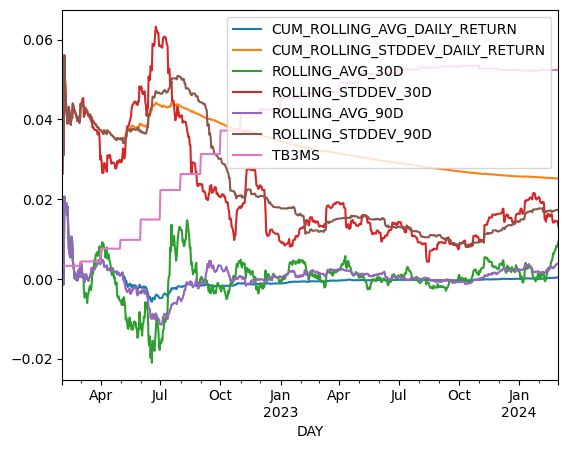

In [125]:
merged_df_filtered.plot()

In [126]:
merged_df_filtered.tail()

,CUM_ROLLING_AVG_DAILY_RETURN,CUM_ROLLING_STDDEV_DAILY_RETURN,ROLLING_AVG_30D,ROLLING_STDDEV_30D,ROLLING_AVG_90D,ROLLING_STDDEV_90D,TB3MS
DAY,,,,,,,
2024-02-26,0.000345,0.025224,0.007608,0.014629,0.003434,0.017219,0.0524
2024-02-27,0.000366,0.025213,0.008359,0.014444,0.003680,0.017235,0.0524
2024-02-28,0.000391,0.025206,0.008365,0.014448,0.003846,0.017317,0.0524
2024-02-29,0.000399,0.025190,0.008118,0.014421,0.003781,0.017297,0.0524
2024-03-01,0.000414,0.025177,0.009287,0.013187,0.003681,0.017220,0.0524


In [127]:
daily_rf_rate = (1 + merged_df_filtered['TB3MS'])**(1/252) - 1

# Annualize the standard deviations (assuming 252 trading days in a year)
annualized_stddev_cum = merged_df_filtered['CUM_ROLLING_STDDEV_DAILY_RETURN'] * (365**0.5)
annualized_stddev_30d = merged_df_filtered['ROLLING_STDDEV_30D'] * (365**0.5)
annualized_stddev_90d = merged_df_filtered['ROLLING_STDDEV_90D'] * (365**0.5)

# Calculate Sharpe Ratios for each period
merged_df_filtered['SHARPE_RATIO_CUM'] = (merged_df_filtered['CUM_ROLLING_AVG_DAILY_RETURN'] - daily_rf_rate) / annualized_stddev_cum
merged_df_filtered['SHARPE_RATIO_30D'] = (merged_df_filtered['ROLLING_AVG_30D'] - daily_rf_rate) / annualized_stddev_30d
merged_df_filtered['SHARPE_RATIO_90D'] = (merged_df_filtered['ROLLING_AVG_90D'] - daily_rf_rate) / annualized_stddev_90d

# View the resulting DataFrame
merged_df_filtered[['SHARPE_RATIO_CUM', 'SHARPE_RATIO_30D', 'SHARPE_RATIO_90D']].head()

C:\Users\brandyns pc\AppData\Local\Temp\ipykernel_16192\3343742360.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df_filtered['SHARPE_RATIO_CUM'] = (merged_df_filtered['CUM_ROLLING_AVG_DAILY_RETURN'] - daily_rf_rate) / annualized_stddev_cum
C:\Users\brandyns pc\AppData\Local\Temp\ipykernel_16192\3343742360.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df_filtered['SHARPE_RATIO_30D'] = (merged_df_filtered['ROLLING_AVG_30D'] - daily_rf_rate) / annualized_stddev_30d
C:\Users\brandyns 

,SHARPE_RATIO_CUM,SHARPE_RATIO_30D,SHARPE_RATIO_90D
DAY,,,
2022-02-01,0.036986,0.036986,0.036986
2022-02-02,-0.000693,-0.000693,-0.000693
2022-02-03,-0.002346,-0.002346,-0.002346
2022-02-04,0.019239,0.019239,0.019239
2022-02-05,0.019713,0.019713,0.019713


<Axes: xlabel='DAY'>

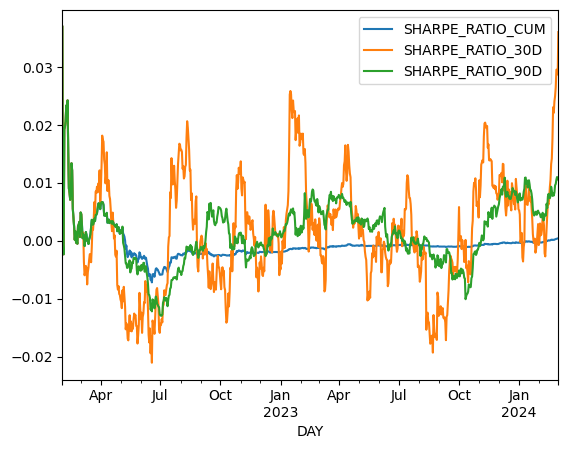

In [128]:
merged_df_filtered[['SHARPE_RATIO_CUM', 'SHARPE_RATIO_30D', 'SHARPE_RATIO_90D']].plot()

In [168]:
pivot_combined. columns = ['_'.join(col).strip() for col in pivot_combined.columns.values]

In [129]:
citydao_metrics = merged_df_filtered.merge(citydao_index, left_index=True, right_index=True)

<Axes: xlabel='DAY'>

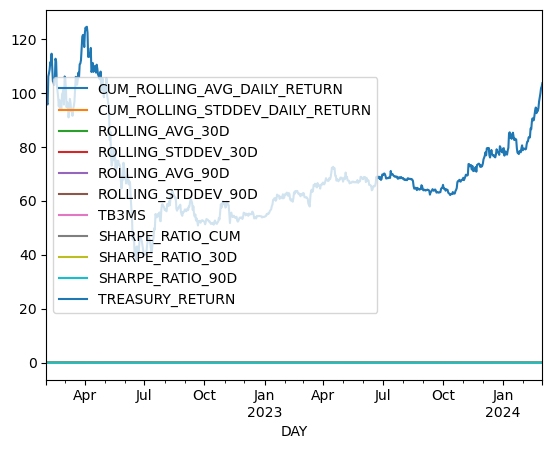

In [131]:
citydao_metrics.plot()

In [176]:
citydao_df = pd.merge(pivot_combined.reset_index(), citydao_metrics.reset_index(), on='DAY', how='inner')

In [178]:
citydao_df['COMPOSITION_WETH'].describe()

count   760.00
mean      0.44
std       0.23
min       0.00
25%       0.39
50%       0.52
75%       0.56
max       0.96
Name: COMPOSITION_WETH, dtype: float64

In [205]:
citydao_cf_path = '../data/citydao_cf.csv'

In [206]:
citydao_cf = pd.read_csv(citydao_cf_path)

In [207]:
citydao_cf.dropna(inplace=True)
citydao_cf

,MONTH,INFLOW,OUTFLOW,NET_CASH_FLOW
0,2024-04-01 00:00:00.000,0.00,0.00,0.00
1,2024-03-01 00:00:00.000,39.29,"-2,451.51","-2,412.22"
2,2024-02-01 00:00:00.000,236.74,"-4,131.31","-3,894.57"
3,2024-01-01 00:00:00.000,166.26,"-20,628.66","-20,462.40"
4,2023-12-01 00:00:00.000,275.96,"-6,027.33","-5,751.37"
5,2023-11-01 00:00:00.000,232.06,-70.52,161.54
6,2023-10-01 00:00:00.000,56.15,"-12,034.39","-11,978.24"
7,2023-09-01 00:00:00.000,"27,972.02","-1,614.21","26,357.82"
8,2023-08-01 00:00:00.000,105.24,"-9,024.91","-8,919.67"
9,2023-07-01 00:00:00.000,83.45,"-1,560.16","-1,476.70"


In [208]:
citydao_cf = citydao_cf[citydao_cf['MONTH'] > '2022-02-01']

In [209]:
citydao_cf['MONTH'] = pd.to_datetime(citydao_cf['MONTH'])
citydao_cf.set_index('MONTH',inplace=True)

C:\Users\brandyns pc\AppData\Local\Temp\ipykernel_16192\164232992.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  citydao_cf['MONTH'] = pd.to_datetime(citydao_cf['MONTH'])


In [217]:
citydao_cf.columns = [f'citydao_treasury_{col}' if col != 'MONTH' else col for col in citydao_cf.columns]

In [218]:
citydao_cf

,citydao_treasury_INFLOW,citydao_treasury_OUTFLOW,citydao_treasury_NET_CASH_FLOW
MONTH,,,
2024-04-01,0.00,0.00,0.00
2024-03-01,39.29,"-2,451.51","-2,412.22"
2024-02-01,236.74,"-4,131.31","-3,894.57"
2024-01-01,166.26,"-20,628.66","-20,462.40"
2023-12-01,275.96,"-6,027.33","-5,751.37"
2023-11-01,232.06,-70.52,161.54
2023-10-01,56.15,"-12,034.39","-11,978.24"
2023-09-01,"27,972.02","-1,614.21","26,357.82"
2023-08-01,105.24,"-9,024.91","-8,919.67"


In [188]:
citydao_burn_path = '../data/citydao_burnrate.csv'
citydao_burn = pd.read_csv(citydao_burn_path)

In [214]:
citydao_burn.dropna(inplace=True)

In [215]:
citydao_burn['MONTH'] = pd.to_datetime(citydao_burn['MONTH'])
citydao_burn.set_index('MONTH', inplace=True)

In [219]:
citydao_burn.columns = [f'citydao_treasury_{col}' if col != 'MONTH' else col for col in citydao_burn.columns]

In [220]:
citydao_burn

,citydao_treasury_AVG_BALANCE,citydao_treasury_GROSS_BURN_RATE,citydao_treasury_NET_BURN_RATE,citydao_treasury_TARGET_BURN_RATE,citydao_treasury_GROSS_BURN_RATE_HEALTH_RATIO,citydao_treasury_NET_BURN_RATE_HEALTH_RATIO
MONTH,,,,,,
2024-04-01,"2,795,269.37","1,503.02","-1,502.99","232,939.11",0.01,0.01
2024-03-01,"3,233,439.20","387,241.51","-387,091.99","269,453.27",1.44,1.44
2024-02-01,"2,790,493.02","4,131.31","-3,894.57","232,541.09",0.02,0.02
2024-01-01,"2,571,340.53","20,628.66","-20,462.40","214,278.38",0.10,0.10
2023-12-01,"2,517,359.90","6,027.33","-5,751.37","209,779.99",0.03,0.03
2023-11-01,"2,353,125.73",70.52,161.54,"196,093.81",0.00,0.00
2023-10-01,"2,135,105.62","12,034.39","-11,978.24","177,925.47",0.07,0.07
2023-09-01,"2,097,141.97","1,614.21","26,357.82","174,761.83",0.01,0.15
2023-08-01,"2,189,108.09","9,024.91","-8,919.67","182,425.67",0.05,0.05


In [222]:
dataset = pd.merge(citydao_burn, citydao_cf, left_index=True, right_index=True, how='left')

<Axes: xlabel='MONTH'>

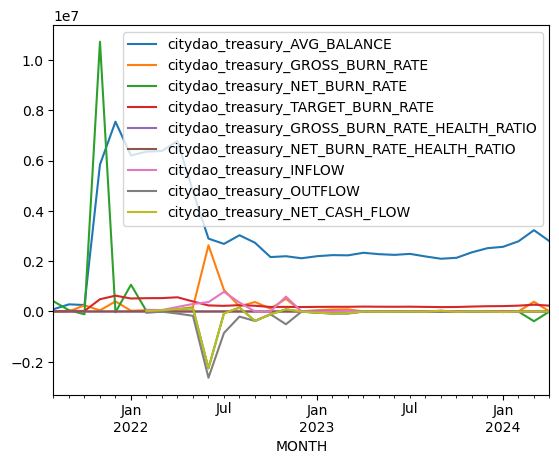

In [224]:
dataset.plot()

In [225]:
dataset = dataset.resample('D').ffill()

In [226]:
dataset

,citydao_treasury_AVG_BALANCE,citydao_treasury_GROSS_BURN_RATE,citydao_treasury_NET_BURN_RATE,citydao_treasury_TARGET_BURN_RATE,citydao_treasury_GROSS_BURN_RATE_HEALTH_RATIO,citydao_treasury_NET_BURN_RATE_HEALTH_RATIO,citydao_treasury_INFLOW,citydao_treasury_OUTFLOW,citydao_treasury_NET_CASH_FLOW
MONTH,,,,,,,,,
2021-08-01,"90,434.88","1,074.11","405,710.96","7,536.24",0.14,53.83,NaN,NaN,NaN
2021-08-02,"90,434.88","1,074.11","405,710.96","7,536.24",0.14,53.83,NaN,NaN,NaN
2021-08-03,"90,434.88","1,074.11","405,710.96","7,536.24",0.14,53.83,NaN,NaN,NaN
2021-08-04,"90,434.88","1,074.11","405,710.96","7,536.24",0.14,53.83,NaN,NaN,NaN
2021-08-05,"90,434.88","1,074.11","405,710.96","7,536.24",0.14,53.83,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2024-03-28,"3,233,439.20","387,241.51","-387,091.99","269,453.27",1.44,1.44,39.29,"-2,451.51","-2,412.22"
2024-03-29,"3,233,439.20","387,241.51","-387,091.99","269,453.27",1.44,1.44,39.29,"-2,451.51","-2,412.22"
2024-03-30,"3,233,439.20","387,241.51","-387,091.99","269,453.27",1.44,1.44,39.29,"-2,451.51","-2,412.22"


In [227]:
citydao_data = pd.merge(dataset,citydao_metrics, left_index=True, right_index=True, how='right')

In [231]:
citydao_data.columns

Index(['citydao_treasury_AVG_BALANCE', 'citydao_treasury_GROSS_BURN_RATE',
       'citydao_treasury_NET_BURN_RATE', 'citydao_treasury_TARGET_BURN_RATE',
       'citydao_treasury_GROSS_BURN_RATE_HEALTH_RATIO',
       'citydao_treasury_NET_BURN_RATE_HEALTH_RATIO',
       'citydao_treasury_INFLOW', 'citydao_treasury_OUTFLOW',
       'citydao_treasury_NET_CASH_FLOW', 'CUM_ROLLING_AVG_DAILY_RETURN',
       'CUM_ROLLING_STDDEV_DAILY_RETURN', 'ROLLING_AVG_30D',
       'ROLLING_STDDEV_30D', 'ROLLING_AVG_90D', 'ROLLING_STDDEV_90D', 'TB3MS',
       'SHARPE_RATIO_CUM', 'SHARPE_RATIO_30D', 'SHARPE_RATIO_90D',
       'TREASURY_RETURN'],
      dtype='object')